In [1]:

import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from PIL import Image
import cv2

In [2]:
class CFG:
    # classes
    CLASSES = ['dry', 'overripe', 'ripe', 'semi_ripe', 'unripe']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)  
    # FOLDERS = ['train', 'val', 'test']
    # paths
    CUSTOM_DATASET_DIR = './data/'
    OUTPUT_DIR = './'


# Visualize image and batch

In [27]:
# Read all images from the data/images/ directory
def load_image_paths():
    """Load all image paths from the data/images directory"""
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
    image_paths = []
    
    for extension in image_extensions:
        pattern = os.path.join(CFG.CUSTOM_DATASET_DIR, 'images', extension)
        image_paths.extend(glob.glob(pattern))
    
    return sorted(image_paths)

def get_class_from_filename(filename):
    """Extract class label from filename based on the class names in CFG.CLASSES"""
    filename_lower = filename.lower()
    for class_name in CFG.CLASSES:
        if class_name in filename_lower:
            return class_name
    return 'unknown'

def load_yolo_labels(label_path):
    """
    Load YOLO format labels from a text file
    
    Args:
        label_path: Path to the label file
        
    Returns:
        List of tuples (class_id, x_center, y_center, width, height) in normalized coordinates
    """
    labels = []
    if os.path.exists(label_path):
        try:
            with open(label_path, 'r') as f:
                for line in f:
                    line = line.strip()
                    if line:
                        parts = line.split()
                        if len(parts) >= 5:
                            class_id = int(parts[0])
                            x_center = float(parts[1])
                            y_center = float(parts[2])
                            width = float(parts[3])
                            height = float(parts[4])
                            labels.append((class_id, x_center, y_center, width, height))
        except Exception as e:
            print(f"Error reading label file {label_path}: {e}")
    
    return labels

def yolo_to_bbox(x_center, y_center, width, height, img_width, img_height):
    """
    Convert YOLO format (normalized) to bounding box coordinates
    
    Args:
        x_center, y_center, width, height: YOLO normalized coordinates
        img_width, img_height: Image dimensions
        
    Returns:
        (x_min, y_min, x_max, y_max) in pixel coordinates
    """
    x_min = int((x_center - width/2) * img_width)
    y_min = int((y_center - height/2) * img_height)
    x_max = int((x_center + width/2) * img_width)
    y_max = int((y_center + height/2) * img_height)
    
    return x_min, y_min, x_max, y_max

def plot_one_image(image_path=None, figsize=(8, 6), show_bbox=True):
    """
    Plot a single image with optional bounding boxes
    
    Args:
        image_path: Path to the image. If None, randomly selects one
        figsize: Figure size for the plot
        show_bbox: Whether to show bounding boxes from labels
    """
    if image_path is None:
        image_paths = load_image_paths()
        if not image_paths:
            print("No images found in the directory!")
            return
        image_path = random.choice(image_paths)
    
    # Load and display image
    try:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_height, img_width = image.shape[:2]
        
        # Get class from filename
        filename = os.path.basename(image_path)
        class_label = get_class_from_filename(filename)
        
        # Create figure and axis
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        ax.imshow(image)
        
        # Load and draw bounding boxes if requested
        bbox_count = 0
        if show_bbox:
            # Get corresponding label file
            label_filename = os.path.splitext(filename)[0] + '.txt'
            label_path = os.path.join(CFG.CUSTOM_DATASET_DIR, 'labels', label_filename)
            
            labels = load_yolo_labels(label_path)
            bbox_count = len(labels)
            
            # Define colors for each class
            colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
            
            for class_id, x_center, y_center, width, height in labels:
                # Convert YOLO to bbox coordinates
                x_min, y_min, x_max, y_max = yolo_to_bbox(
                    x_center, y_center, width, height, img_width, img_height
                )
                
                # Create rectangle
                rect = Rectangle(
                    (x_min, y_min), 
                    x_max - x_min, 
                    y_max - y_min,
                    linewidth=2, 
                    edgecolor=colors[class_id % len(colors)], 
                    facecolor='none'
                )
                ax.add_patch(rect)
                
                # Add class label
                class_name = CFG.CLASSES[class_id] if class_id < len(CFG.CLASSES) else f'class_{class_id}'
                ax.text(
                    x_min, y_min - 5, 
                    class_name, 
                    color=colors[class_id % len(colors)], 
                    fontsize=10, 
                    weight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7)
                )
        
        title = f'Class: {class_label} | Bboxes: {bbox_count}\nFilename: {filename}'
        print(filename)
        ax.set_title(title, fontsize=12)
        ax.axis('off')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")

def plot_batch_images(batch_size=8, figsize=(15, 10), random_selection=True, show_bbox=True):
    """
    Plot a batch of images in a grid with optional bounding boxes
    
    Args:
        batch_size: Number of images to display
        figsize: Figure size for the plot
        random_selection: If True, randomly select images. If False, select first batch_size images
        show_bbox: Whether to show bounding boxes from labels
    """
    image_paths = load_image_paths()
    
    if not image_paths:
        print("No images found in the directory!")
        return
    
    if batch_size > len(image_paths):
        batch_size = len(image_paths)
        print(f"Reducing batch size to {batch_size} (total available images)")
    
    # Select images
    if random_selection:
        selected_paths = random.sample(image_paths, batch_size)
    else:
        selected_paths = image_paths[:batch_size]
    
    # Calculate grid dimensions
    cols = int(np.ceil(np.sqrt(batch_size)))
    rows = int(np.ceil(batch_size / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Handle case where there's only one subplot
    if batch_size == 1:
        axes = [axes]
    elif rows == 1 or cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    # Define colors for each class
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
    
    for i, image_path in enumerate(selected_paths):
        try:
            # Load image
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            img_height, img_width = image.shape[:2]
            
            # Get class from filename
            filename = os.path.basename(image_path)
            class_label = get_class_from_filename(filename)
            
            # Plot image
            axes[i].imshow(image)
            
            # Load and draw bounding boxes if requested
            bbox_count = 0
            if show_bbox:
                # Get corresponding label file
                label_filename = os.path.splitext(filename)[0] + '.txt'
                label_path = os.path.join(CFG.CUSTOM_DATASET_DIR, 'labels', label_filename)
                
                labels = load_yolo_labels(label_path)
                bbox_count = len(labels)
                
                for class_id, x_center, y_center, width, height in labels:
                    # Convert YOLO to bbox coordinates
                    x_min, y_min, x_max, y_max = yolo_to_bbox(
                        x_center, y_center, width, height, img_width, img_height
                    )
                    
                    # Create rectangle
                    rect = Rectangle(
                        (x_min, y_min), 
                        x_max - x_min, 
                        y_max - y_min,
                        linewidth=1.5, 
                        edgecolor=colors[class_id % len(colors)], 
                        facecolor='none'
                    )
                    axes[i].add_patch(rect)
                    
                    # Add class label (smaller for batch view)
                    class_name = CFG.CLASSES[class_id] if class_id < len(CFG.CLASSES) else f'class_{class_id}'
                    axes[i].text(
                        x_min, y_min - 2, 
                        class_name, 
                        color=colors[class_id % len(colors)], 
                        fontsize=8, 
                        weight='bold',
                        bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.7)
                    )
            
            title = f'{class_label} | B:{bbox_count}\n{filename[:15]}...'
            axes[i].set_title(title, fontsize=9)
            axes[i].axis('off')
            
        except Exception as e:
            axes[i].text(0.5, 0.5, f'Error loading\n{os.path.basename(image_path)}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(batch_size, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Load all image paths
image_paths = load_image_paths()
print(f"Found {len(image_paths)} images in {CFG.CUSTOM_DATASET_DIR}images/")

# Display first few image paths as examples
if image_paths:
    print("\nFirst 5 image paths:")
    for i, path in enumerate(image_paths[:5]):
        print(f"{i+1}. {path}")

# Check for labels
label_dir = os.path.join(CFG.CUSTOM_DATASET_DIR, 'labels')
if os.path.exists(label_dir):
    label_files = glob.glob(os.path.join(label_dir, '*.txt'))
    print(f"\nFound {len(label_files)} label files in {label_dir}")
else:
    print(f"\nWarning: Labels directory not found at {label_dir}")

Found 3541 images in ./data/images/

First 5 image paths:
1. ./data/images/017df65b-IMG_20241224_094633.jpg
2. ./data/images/01a17c48-IMG_20241224_093501.jpg
3. ./data/images/020339c2-IMG_20241224_103355.jpg
4. ./data/images/02263ffb-IMG_20241224_094305.jpg
5. ./data/images/022e25f5-IMG_20241224_093535.jpg

Found 3541 label files in ./data/labels


IMG_20231009_074155_jpg.rf.be0864b40de85508c4fc76304f4098af.jpg


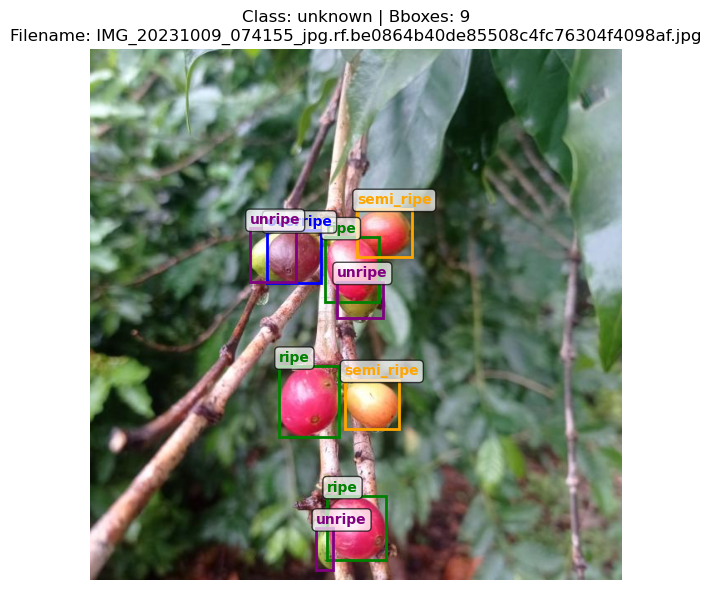

In [101]:
# Plot a single random image
plot_one_image()

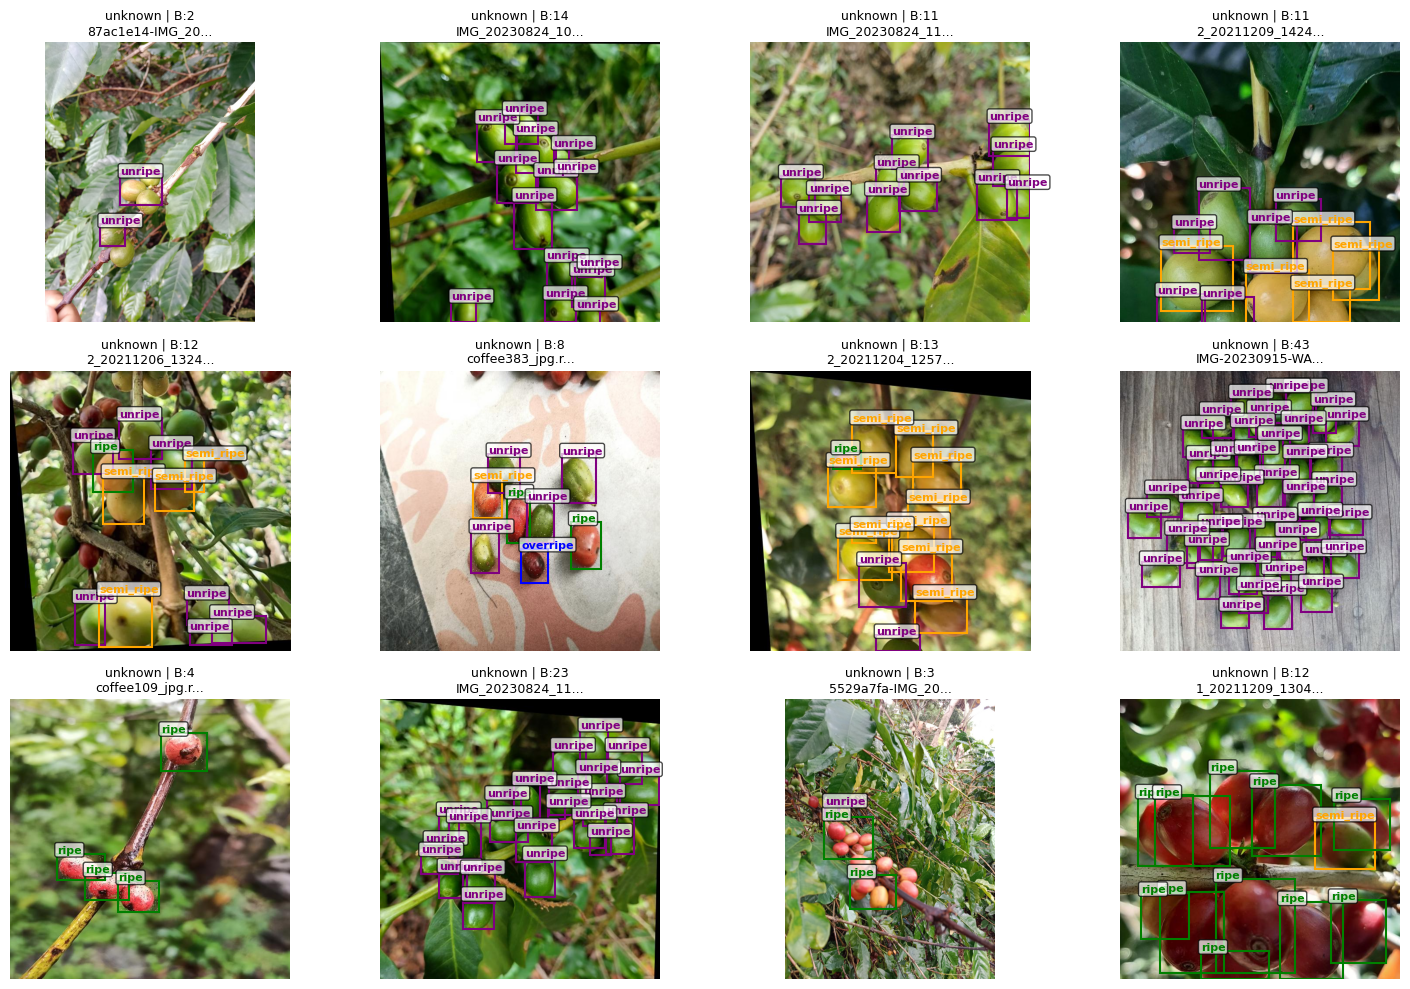

In [11]:
plot_batch_images(batch_size=12, show_bbox=True)

# Distribution

In [109]:
def analyze_dataset_distribution():
    """
    Analyze and collect statistics from the dataset
    
    Returns:
        dict: Dictionary containing all distribution data
    """
    image_paths = load_image_paths()
    label_dir = os.path.join(CFG.CUSTOM_DATASET_DIR, 'labels')
    
    # Initialize data collection
    data = {
        'class_counts': {class_name: 0 for class_name in CFG.CLASSES},
        'class_counts_from_labels': [0] * len(CFG.CLASSES),
        'image_widths': [],
        'image_heights': [],
        'aspect_ratios': [],
        'bbox_widths': [],
        'bbox_heights': [],
        'bbox_aspect_ratios': [],
        'bboxes_per_image': [],
        'total_images': len(image_paths),
        'total_labels': 0
    }
    
    print(f"Analyzing {len(image_paths)} images...")
    
    for i, image_path in enumerate(image_paths):
        try:
            # Load image to get dimensions
            image = cv2.imread(image_path)
            if image is None:
                continue
                
            img_height, img_width = image.shape[:2]
            data['image_widths'].append(img_width)
            data['image_heights'].append(img_height)
            data['aspect_ratios'].append(img_width / img_height)
            
            # Get class from filename
            filename = os.path.basename(image_path)
            class_label = get_class_from_filename(filename)
            if class_label in data['class_counts']:
                data['class_counts'][class_label] += 1
            
            # Load corresponding label file
            label_filename = os.path.splitext(filename)[0] + '.txt'
            label_path = os.path.join(label_dir, label_filename)
            
            labels = load_yolo_labels(label_path)
            data['bboxes_per_image'].append(len(labels))
            data['total_labels'] += len(labels)
            
            # Analyze bounding boxes
            for class_id, x_center, y_center, width, height in labels:
                if 0 <= class_id < len(CFG.CLASSES):
                    data['class_counts_from_labels'][class_id] += 1
                
                # Convert normalized bbox dimensions to pixel dimensions for analysis
                bbox_width_px = width * img_width
                bbox_height_px = height * img_height
                
                data['bbox_widths'].append(bbox_width_px)
                data['bbox_heights'].append(bbox_height_px)
                data['bbox_aspect_ratios'].append(bbox_width_px / bbox_height_px)
        
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
        
        # Progress indicator
        if (i + 1) % 100 == 0:
            print(f"Processed {i + 1}/{len(image_paths)} images...")
    
    print(f"Analysis complete! Found {data['total_labels']} total annotations.")
    return data

def plot_label_distribution(data):
    """Plot distribution of class labels from annotations only"""
    # Only use data from label files (bounding boxes)
    label_counts = data['class_counts_from_labels']
    
    # Create a single plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Define consistent colors
    colors = plt.cm.Set3(np.linspace(0, 1, len(CFG.CLASSES)))
    
    # Create bar plot
    bars = ax.bar(CFG.CLASSES, label_counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    ax.set_title('Class Distribution (from label annotations)', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Coffee Bean Maturity Classes', fontsize=14, fontweight='bold')
    ax.set_ylabel('Number of Bounding Boxes', fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
    # Add value labels on bars
    max_count = max(label_counts) if label_counts else 1
    for bar, count in zip(bars, label_counts):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max_count*0.01, 
                str(count), ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    # Add grid for better readability
    ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
    ax.set_axisbelow(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("\n=== Label Distribution Summary ===")
    print("From annotations:")
    total_annotations = sum(label_counts)
    for i, class_name in enumerate(CFG.CLASSES):
        count = label_counts[i]
        percentage = (count / total_annotations) * 100 if total_annotations > 0 else 0
        print(f"  {class_name}: {count} bboxes ({percentage:.1f}%)")
    
    print(f"\nTotal annotations: {total_annotations}")
    
    # Calculate class balance metrics
    if total_annotations > 0:
        max_count = max(label_counts)
        min_count = min([c for c in label_counts if c > 0])  # Exclude zero counts
        class_balance_ratio = min_count / max_count if max_count > 0 else 0
        print(f"Class balance ratio (min/max): {class_balance_ratio:.3f}")
        
        # Most and least represented classes
        max_class = CFG.CLASSES[label_counts.index(max_count)]
        min_class = CFG.CLASSES[label_counts.index(min_count)] if min_count in label_counts else "None"
        print(f"Most represented class: {max_class} ({max_count} bboxes)")
        print(f"Least represented class: {min_class} ({min_count} bboxes)")

def plot_image_dimensions_distribution(data):
    """Plot distribution of image widths, heights, and aspect ratios"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Image Dimensions Distribution Analysis', fontsize=18, fontweight='bold', y=0.98)
    
    # Define consistent colors
    colors = ['#87CEEB', '#F08080', '#90EE90', '#DDA0DD']  # skyblue, lightcoral, lightgreen, plum
    
    # Image widths
    axes[0, 0].hist(data['image_widths'], bins=30, color=colors[0], alpha=0.8, edgecolor='black', linewidth=0.8)
    axes[0, 0].set_title('Distribution of Image Widths', fontsize=14, fontweight='bold', pad=15)
    axes[0, 0].set_xlabel('Width (pixels)', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[0, 0].axvline(np.mean(data['image_widths']), color='red', linestyle='--', linewidth=2,
                      label=f'Mean: {np.mean(data["image_widths"]):.0f}')
    axes[0, 0].legend(fontsize=11, framealpha=0.9)
    axes[0, 0].grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
    axes[0, 0].tick_params(labelsize=11)
    
    # Image heights
    axes[0, 1].hist(data['image_heights'], bins=30, color=colors[1], alpha=0.8, edgecolor='black', linewidth=0.8)
    axes[0, 1].set_title('Distribution of Image Heights', fontsize=14, fontweight='bold', pad=15)
    axes[0, 1].set_xlabel('Height (pixels)', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[0, 1].axvline(np.mean(data['image_heights']), color='red', linestyle='--', linewidth=2,
                      label=f'Mean: {np.mean(data["image_heights"]):.0f}')
    axes[0, 1].legend(fontsize=11, framealpha=0.9)
    axes[0, 1].grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
    axes[0, 1].tick_params(labelsize=11)
    
    # Image aspect ratios
    axes[1, 0].hist(data['aspect_ratios'], bins=30, color=colors[2], alpha=0.8, edgecolor='black', linewidth=0.8)
    axes[1, 0].set_title('Distribution of Image Aspect Ratios', fontsize=14, fontweight='bold', pad=15)
    axes[1, 0].set_xlabel('Aspect Ratio (Width/Height)', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[1, 0].axvline(np.mean(data['aspect_ratios']), color='red', linestyle='--', linewidth=2,
                      label=f'Mean: {np.mean(data["aspect_ratios"]):.2f}')
    axes[1, 0].legend(fontsize=11, framealpha=0.9)
    axes[1, 0].grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
    axes[1, 0].tick_params(labelsize=11)
    
    # Scatter plot: Width vs Height
    axes[1, 1].scatter(data['image_widths'], data['image_heights'], alpha=0.6, color=colors[3], 
                      s=30, edgecolors='black', linewidth=0.5)
    axes[1, 1].set_title('Image Dimensions Scatter Plot', fontsize=14, fontweight='bold', pad=15)
    axes[1, 1].set_xlabel('Width (pixels)', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Height (pixels)', fontsize=12, fontweight='bold')
    
    # Add diagonal lines for common aspect ratios
    max_dim = max(max(data['image_widths']), max(data['image_heights']))
    x_line = np.linspace(0, max_dim, 100)
    axes[1, 1].plot(x_line, x_line, 'r--', alpha=0.7, linewidth=2, label='1:1')
    axes[1, 1].plot(x_line, x_line * 3/4, 'g--', alpha=0.7, linewidth=2, label='4:3')
    axes[1, 1].plot(x_line, x_line * 9/16, 'b--', alpha=0.7, linewidth=2, label='16:9')
    axes[1, 1].legend(fontsize=11, framealpha=0.9)
    axes[1, 1].grid(alpha=0.3, linestyle='--', linewidth=0.8)
    axes[1, 1].tick_params(labelsize=11)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\n=== Image Dimensions Summary ===")
    print(f"Width  - Min: {min(data['image_widths']):,}, Max: {max(data['image_widths']):,}, Mean: {np.mean(data['image_widths']):.1f}")
    print(f"Height - Min: {min(data['image_heights']):,}, Max: {max(data['image_heights']):,}, Mean: {np.mean(data['image_heights']):.1f}")
    print(f"Aspect Ratio - Min: {min(data['aspect_ratios']):.2f}, Max: {max(data['aspect_ratios']):.2f}, Mean: {np.mean(data['aspect_ratios']):.2f}")

Starting comprehensive dataset analysis...
Analyzing 3541 images...
Processed 100/3541 images...
Processed 200/3541 images...
Processed 300/3541 images...
Processed 400/3541 images...
Processed 500/3541 images...
Processed 600/3541 images...
Processed 700/3541 images...
Processed 800/3541 images...
Processed 900/3541 images...
Processed 1000/3541 images...
Processed 1100/3541 images...
Processed 1200/3541 images...
Processed 1300/3541 images...
Processed 1400/3541 images...
Processed 1500/3541 images...
Processed 1600/3541 images...
Processed 1700/3541 images...
Processed 1800/3541 images...
Processed 1900/3541 images...
Processed 2000/3541 images...
Processed 2100/3541 images...
Processed 2200/3541 images...
Processed 2300/3541 images...
Processed 2400/3541 images...
Processed 2500/3541 images...
Processed 2600/3541 images...
Processed 2700/3541 images...
Processed 2800/3541 images...
Processed 2900/3541 images...
Processed 3000/3541 images...
Processed 3100/3541 images...
Processed 3

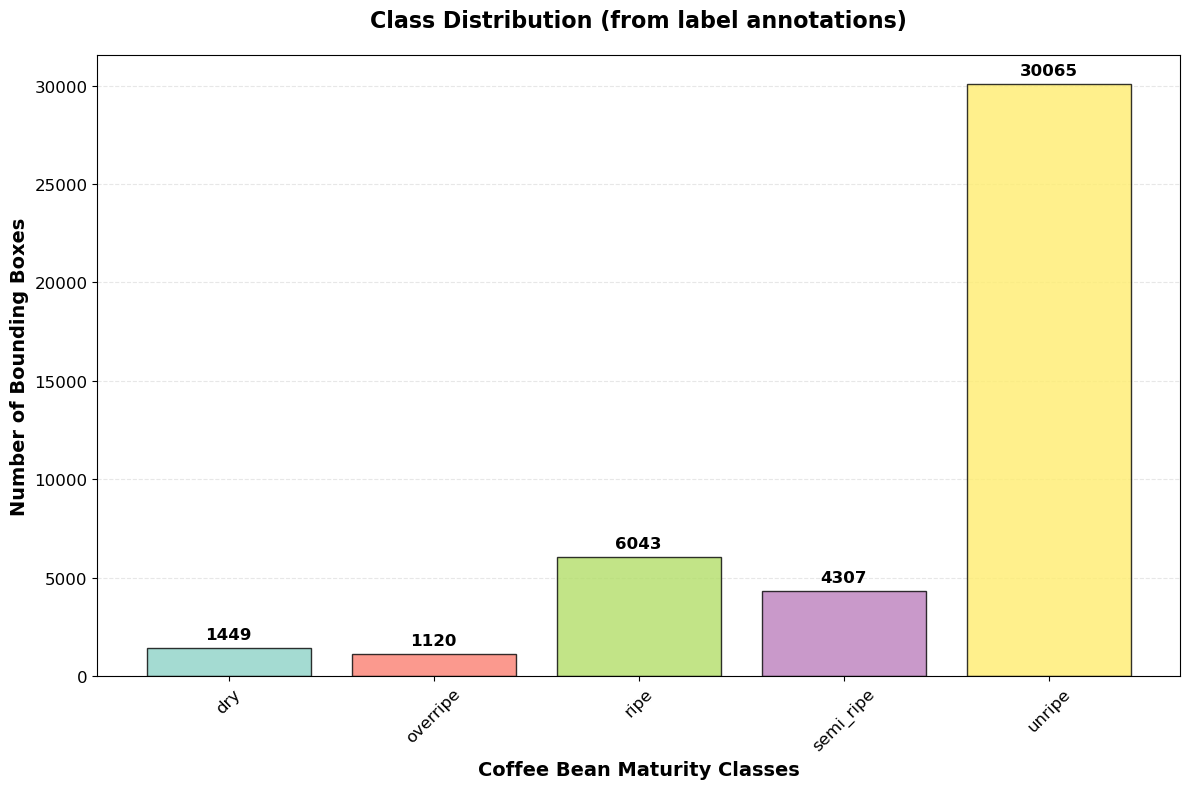


=== Label Distribution Summary ===
From annotations:
  dry: 1449 bboxes (3.4%)
  overripe: 1120 bboxes (2.6%)
  ripe: 6043 bboxes (14.1%)
  semi_ripe: 4307 bboxes (10.0%)
  unripe: 30065 bboxes (69.9%)

Total annotations: 42984
Class balance ratio (min/max): 0.037
Most represented class: unripe (30065 bboxes)
Least represented class: overripe (1120 bboxes)

2. Plotting image dimensions distribution...


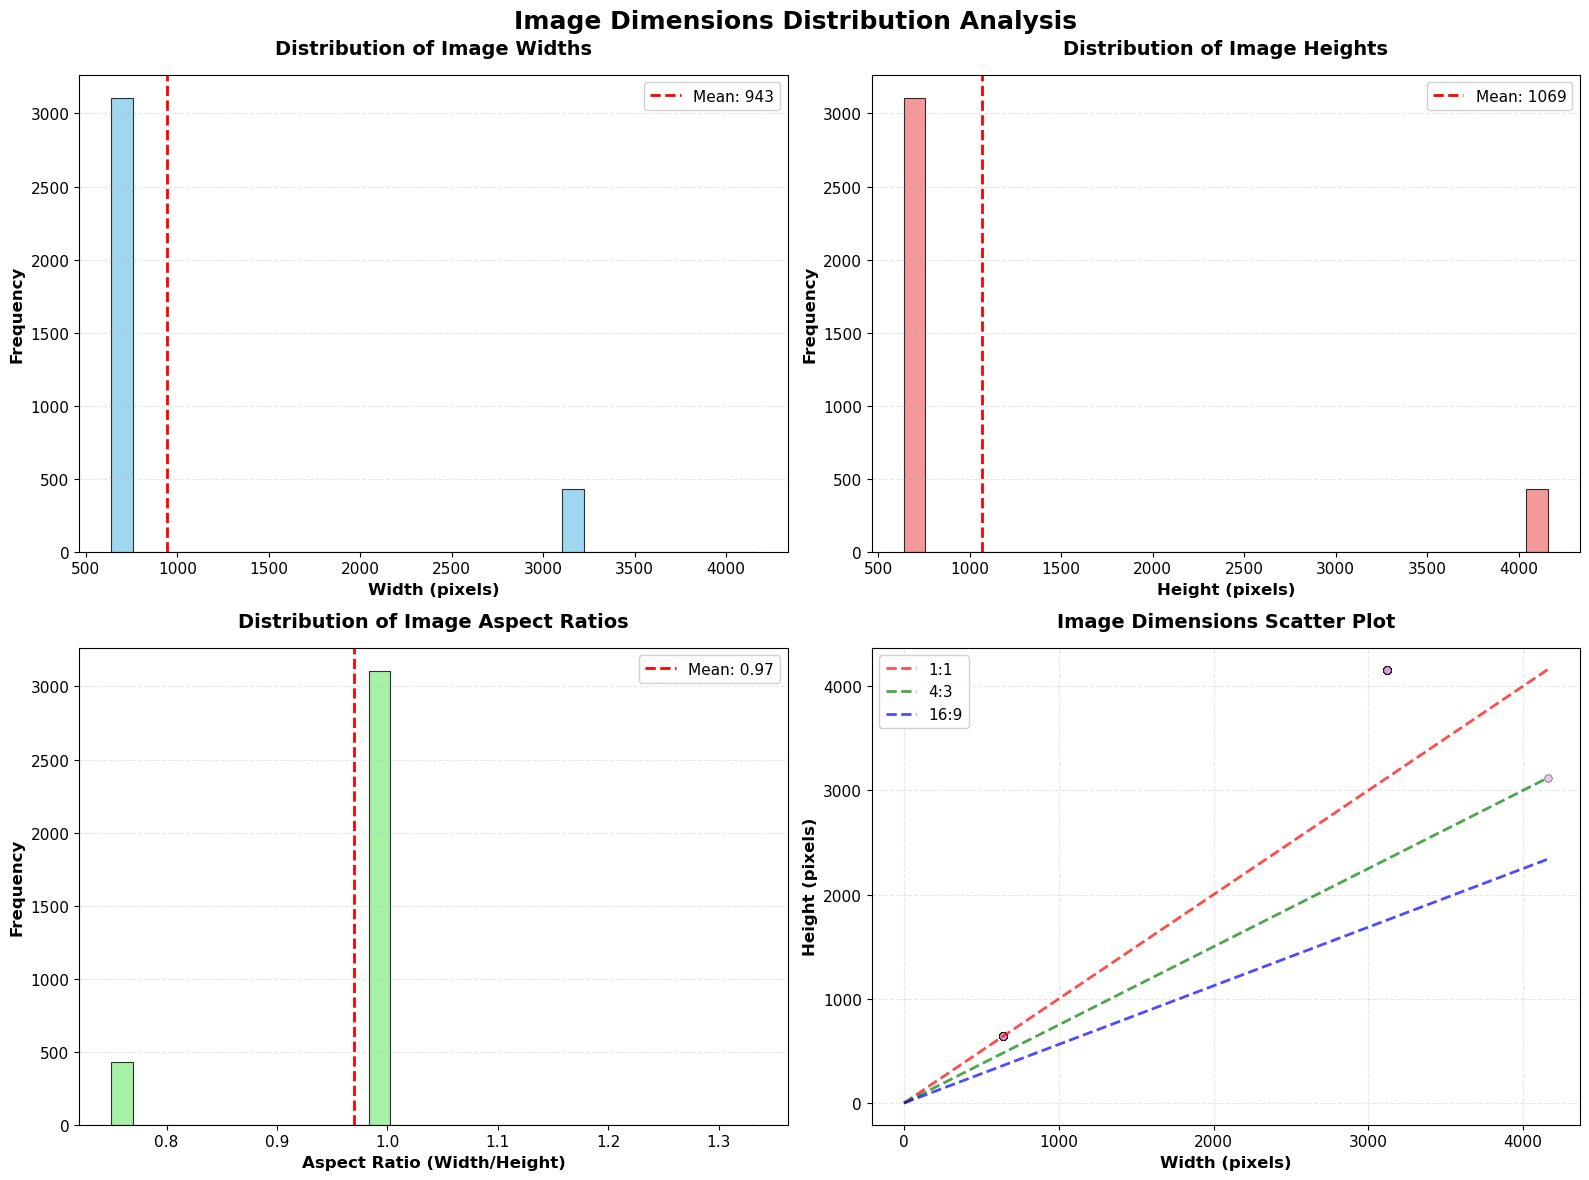


=== Image Dimensions Summary ===
Width  - Min: 640, Max: 4,160, Mean: 942.9
Height - Min: 640, Max: 4,160, Mean: 1069.1
Aspect Ratio - Min: 0.75, Max: 1.33, Mean: 0.97

=== Overall Dataset Summary ===
Total Images: 3,541
Total Annotations: 42,984
Average Annotations per Image: 12.14


In [110]:
def plot_comprehensive_distribution():
    """Plot all distributions in a comprehensive analysis"""
    print("Starting comprehensive dataset analysis...")
    
    # Analyze the dataset
    data = analyze_dataset_distribution()
    
    # Plot all distributions
    print("\n1. Plotting label distribution...")
    plot_label_distribution(data)
    
    print("\n2. Plotting image dimensions distribution...")
    plot_image_dimensions_distribution(data)
    
    print(f"\n=== Overall Dataset Summary ===")
    print(f"Total Images: {data['total_images']:,}")
    print(f"Total Annotations: {data['total_labels']:,}")
    print(f"Average Annotations per Image: {data['total_labels']/data['total_images']:.2f}")
    
    return data

# Run the comprehensive analysis
dataset_stats = plot_comprehensive_distribution()

In [111]:
def preprocess_dataset_balance(target_annotations_per_class=1500, dry_run=False):
    """
    Preprocess dataset to balance annotations per class
    
    Args:
        target_annotations_per_class: Maximum number of annotations per class
        dry_run: If True, only show what would be done without making changes
    
    Returns:
        dict: Statistics about the preprocessing
    """
    print(f"=== Dataset Preprocessing: Target {target_annotations_per_class} annotations per class ===")
    
    # First, analyze current distribution
    data = analyze_dataset_distribution()
    label_dir = os.path.join(CFG.CUSTOM_DATASET_DIR, 'labels')
    image_dir = os.path.join(CFG.CUSTOM_DATASET_DIR, 'images')
    
    # Get all label files and their annotations
    label_files = glob.glob(os.path.join(label_dir, '*.txt'))
    
    # Track annotations by class and file
    class_annotations = {i: [] for i in range(len(CFG.CLASSES))}  # {class_id: [(file_path, line_idx, annotation)]}
    file_annotations = {}  # {file_path: [annotations]}
    
    print(f"\nAnalyzing {len(label_files)} label files...")
    
    # Collect all annotations
    for label_file in label_files:
        labels = load_yolo_labels(label_file)
        file_annotations[label_file] = labels
        
        for line_idx, (class_id, x_center, y_center, width, height) in enumerate(labels):
            if 0 <= class_id < len(CFG.CLASSES):
                annotation_data = (label_file, line_idx, (class_id, x_center, y_center, width, height))
                class_annotations[class_id].append(annotation_data)
    
    # Show current distribution
    print("\n=== Current Distribution ===")
    for class_id, class_name in enumerate(CFG.CLASSES):
        count = len(class_annotations[class_id])
        status = "✓ OK" if count <= target_annotations_per_class else f"⚠ EXCESS: {count - target_annotations_per_class}"
        print(f"  {class_name}: {count} annotations {status}")
    
    # Determine what needs to be removed
    removal_stats = {
        'files_to_process': set(),
        'annotations_to_remove': {},  # {file_path: [line_indices]}
        'files_to_delete': set(),
        'class_reductions': {}
    }
    
    for class_id, class_name in enumerate(CFG.CLASSES):
        annotations = class_annotations[class_id]
        if len(annotations) > target_annotations_per_class:
            # Need to remove excess annotations
            excess_count = len(annotations) - target_annotations_per_class
            removal_stats['class_reductions'][class_name] = excess_count
            
            # Randomly select annotations to remove
            import random
            random.seed(42)  # For reproducibility
            annotations_to_remove = random.sample(annotations, excess_count)
            
            # Group by file
            for file_path, line_idx, annotation in annotations_to_remove:
                if file_path not in removal_stats['annotations_to_remove']:
                    removal_stats['annotations_to_remove'][file_path] = []
                removal_stats['annotations_to_remove'][file_path].append(line_idx)
                removal_stats['files_to_process'].add(file_path)
    
    # Check which files will become empty after removal
    for file_path in removal_stats['files_to_process']:
        original_count = len(file_annotations[file_path])
        removal_count = len(removal_stats['annotations_to_remove'][file_path])
        
        if original_count == removal_count:
            removal_stats['files_to_delete'].add(file_path)
    
    # Show preprocessing plan
    print(f"\n=== Preprocessing Plan ===")
    print(f"Files to modify: {len(removal_stats['files_to_process'])}")
    print(f"Files to delete (will become empty): {len(removal_stats['files_to_delete'])}")
    
    total_annotations_to_remove = 0
    for class_name, count in removal_stats['class_reductions'].items():
        total_annotations_to_remove += count
        print(f"  {class_name}: Remove {count} annotations")
    
    print(f"Total annotations to remove: {total_annotations_to_remove}")
    
    if dry_run:
        print("\n=== DRY RUN - No changes made ===")
        return removal_stats
    
    # Confirm before proceeding
    response = input(f"\nProceed with preprocessing? This will modify {len(removal_stats['files_to_process'])} files and delete {len(removal_stats['files_to_delete'])} file pairs. (y/N): ")
    if response.lower() != 'y':
        print("Preprocessing cancelled.")
        return removal_stats
    
    # Execute preprocessing
    print("\n=== Executing Preprocessing ===")
    
    processed_files = 0
    deleted_files = 0
    
    # Process each file
    for file_path in removal_stats['files_to_process']:
        try:
            if file_path in removal_stats['files_to_delete']:
                # Delete both label and image files
                image_filename = os.path.splitext(os.path.basename(file_path))[0]
                
                # Find corresponding image file
                image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
                image_path = None
                for ext in image_extensions:
                    potential_path = os.path.join(image_dir, image_filename + ext)
                    if os.path.exists(potential_path):
                        image_path = potential_path
                        break
                
                # Delete files
                if os.path.exists(file_path):
                    os.remove(file_path)
                    print(f"  Deleted label: {os.path.basename(file_path)}")
                
                if image_path and os.path.exists(image_path):
                    os.remove(image_path)
                    print(f"  Deleted image: {os.path.basename(image_path)}")
                
                deleted_files += 1
                
            else:
                # Modify the file by removing specific annotations
                original_labels = file_annotations[file_path]
                lines_to_remove = set(removal_stats['annotations_to_remove'][file_path])
                
                # Keep only annotations not in removal list
                filtered_labels = []
                for line_idx, label in enumerate(original_labels):
                    if line_idx not in lines_to_remove:
                        filtered_labels.append(label)
                
                # Write filtered annotations back to file
                with open(file_path, 'w') as f:
                    for class_id, x_center, y_center, width, height in filtered_labels:
                        f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
                
                print(f"  Modified: {os.path.basename(file_path)} (removed {len(lines_to_remove)} annotations)")
                processed_files += 1
        
        except Exception as e:
            print(f"  Error processing {file_path}: {e}")
    
    print(f"\n=== Preprocessing Complete ===")
    print(f"Files modified: {processed_files}")
    print(f"File pairs deleted: {deleted_files}")
    print(f"Total annotations removed: {total_annotations_to_remove}")
    
    # Analyze final distribution
    print(f"\n=== Final Distribution ===")
    final_data = analyze_dataset_distribution()
    
    for i, class_name in enumerate(CFG.CLASSES):
        final_count = final_data['class_counts_from_labels'][i]
        original_count = data['class_counts_from_labels'][i]
        change = final_count - original_count
        print(f"  {class_name}: {original_count} → {final_count} ({change:+d})")
    
    return {
        'original_stats': data,
        'final_stats': final_data,
        'processing_stats': removal_stats,
        'files_modified': processed_files,
        'files_deleted': deleted_files,
        'annotations_removed': total_annotations_to_remove
    }

def create_balanced_dataset_backup():
    """Create a backup of the current dataset before preprocessing"""
    import shutil
    import datetime
    
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    backup_dir = f"./data_backup_{timestamp}"
    
    try:
        print(f"Creating backup at: {backup_dir}")
        shutil.copytree(CFG.CUSTOM_DATASET_DIR, backup_dir)
        print("✓ Backup created successfully")
        return backup_dir
    except Exception as e:
        print(f"✗ Error creating backup: {e}")
        return None

def show_preprocessing_summary(target_annotations=1500):
    """Show what preprocessing would do without making changes"""
    print("=== PREPROCESSING SUMMARY (DRY RUN) ===")
    stats = preprocess_dataset_balance(target_annotations_per_class=target_annotations, dry_run=True)
    return stats

# Usage examples:
print("=== Dataset Preprocessing Tools ===")
print("Available functions:")
print("1. show_preprocessing_summary(1500) - See what would be changed")
print("2. create_balanced_dataset_backup() - Create backup before processing")
print("3. preprocess_dataset_balance(1500) - Execute the preprocessing")

=== Dataset Preprocessing Tools ===
Available functions:
1. show_preprocessing_summary(1500) - See what would be changed
2. create_balanced_dataset_backup() - Create backup before processing
3. preprocess_dataset_balance(1500) - Execute the preprocessing


In [112]:
summary_stats = show_preprocessing_summary(1500)

=== PREPROCESSING SUMMARY (DRY RUN) ===
=== Dataset Preprocessing: Target 1500 annotations per class ===
Analyzing 3541 images...
Processed 100/3541 images...
Processed 200/3541 images...
Processed 300/3541 images...
Processed 400/3541 images...
Processed 500/3541 images...
Processed 600/3541 images...
Processed 700/3541 images...
Processed 800/3541 images...
Processed 900/3541 images...
Processed 1000/3541 images...
Processed 1100/3541 images...
Processed 1200/3541 images...
Processed 1300/3541 images...
Processed 1400/3541 images...
Processed 1500/3541 images...
Processed 1600/3541 images...
Processed 1700/3541 images...
Processed 1800/3541 images...
Processed 1900/3541 images...
Processed 2000/3541 images...
Processed 2100/3541 images...
Processed 2200/3541 images...
Processed 2300/3541 images...
Processed 2400/3541 images...
Processed 2500/3541 images...
Processed 2600/3541 images...
Processed 2700/3541 images...
Processed 2800/3541 images...
Processed 2900/3541 images...
Processed

In [113]:
final_stats = preprocess_dataset_balance(target_annotations_per_class=1500, dry_run=False)

=== Dataset Preprocessing: Target 1500 annotations per class ===
Analyzing 3541 images...
Processed 100/3541 images...
Processed 200/3541 images...
Processed 300/3541 images...
Processed 400/3541 images...
Processed 500/3541 images...
Processed 600/3541 images...
Processed 700/3541 images...
Processed 800/3541 images...
Processed 900/3541 images...
Processed 1000/3541 images...
Processed 1100/3541 images...
Processed 1200/3541 images...
Processed 1300/3541 images...
Processed 1400/3541 images...
Processed 1500/3541 images...
Processed 1600/3541 images...
Processed 1700/3541 images...
Processed 1800/3541 images...
Processed 1900/3541 images...
Processed 2000/3541 images...
Processed 2100/3541 images...
Processed 2200/3541 images...
Processed 2300/3541 images...
Processed 2400/3541 images...
Processed 2500/3541 images...
Processed 2600/3541 images...
Processed 2700/3541 images...
Processed 2800/3541 images...
Processed 2900/3541 images...
Processed 3000/3541 images...
Processed 3100/3541

# Stats after processing

Starting comprehensive dataset analysis...
Analyzing 2354 images...
Processed 100/2354 images...
Processed 200/2354 images...
Processed 300/2354 images...
Processed 400/2354 images...
Processed 500/2354 images...
Processed 600/2354 images...
Processed 700/2354 images...
Processed 800/2354 images...
Processed 900/2354 images...
Processed 1000/2354 images...
Processed 1100/2354 images...
Processed 1200/2354 images...
Processed 1300/2354 images...
Processed 1400/2354 images...
Processed 1500/2354 images...
Processed 1600/2354 images...
Processed 1700/2354 images...
Processed 1800/2354 images...
Processed 1900/2354 images...
Processed 2000/2354 images...
Processed 2100/2354 images...
Processed 2200/2354 images...
Processed 2300/2354 images...
Analysis complete! Found 7069 total annotations.

1. Plotting label distribution...


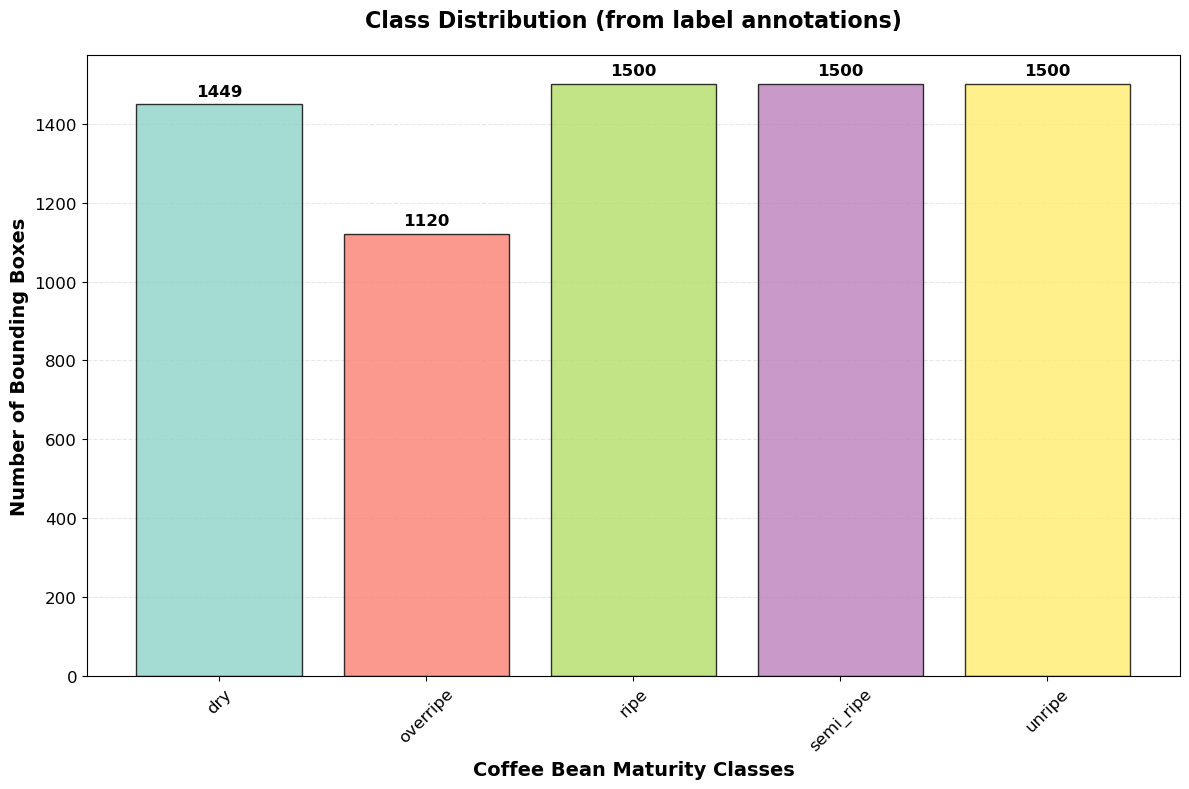


=== Label Distribution Summary ===
From annotations:
  dry: 1449 bboxes (20.5%)
  overripe: 1120 bboxes (15.8%)
  ripe: 1500 bboxes (21.2%)
  semi_ripe: 1500 bboxes (21.2%)
  unripe: 1500 bboxes (21.2%)

Total annotations: 7069
Class balance ratio (min/max): 0.747
Most represented class: ripe (1500 bboxes)
Least represented class: overripe (1120 bboxes)

2. Plotting image dimensions distribution...


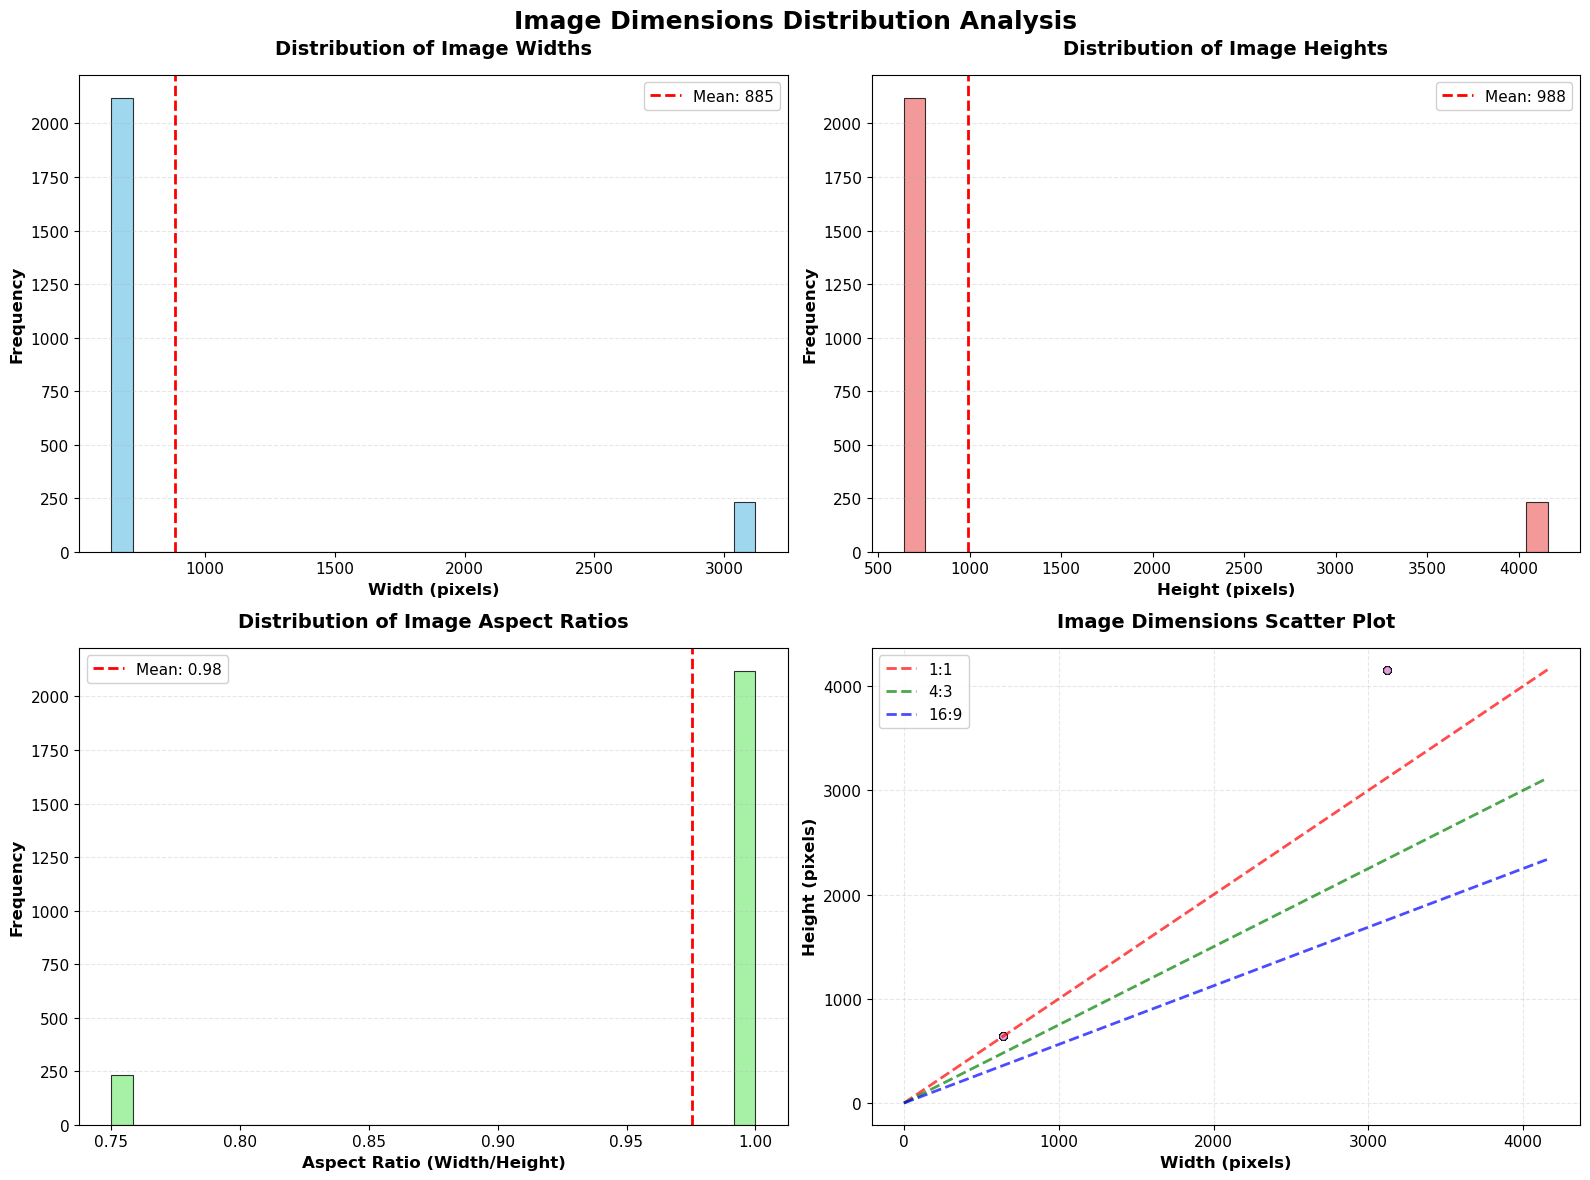


=== Image Dimensions Summary ===
Width  - Min: 640, Max: 3,120, Mean: 885.5
Height - Min: 640, Max: 4,160, Mean: 988.4
Aspect Ratio - Min: 0.75, Max: 1.00, Mean: 0.98

=== Overall Dataset Summary ===
Total Images: 2,354
Total Annotations: 7,069
Average Annotations per Image: 3.00


In [114]:
dataset_stats = plot_comprehensive_distribution()

# Splitting:
- train, test, val: 7, 1.5, 1.5

In [115]:
def split_dataset(train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_seed=42):
    """
    Split dataset into train, validation, and test sets
    
    Args:
        train_ratio: Proportion for training set (default: 0.7)
        val_ratio: Proportion for validation set (default: 0.15)
        test_ratio: Proportion for test set (default: 0.15)
        random_seed: Random seed for reproducible splits
    """
    import shutil
    import random
    from collections import defaultdict
    
    # Verify ratios sum to 1
    total_ratio = train_ratio + val_ratio + test_ratio
    if abs(total_ratio - 1.0) > 0.001:
        print(f"Warning: Ratios sum to {total_ratio}, not 1.0. Normalizing...")
        train_ratio /= total_ratio
        val_ratio /= total_ratio
        test_ratio /= total_ratio
    
    print(f"=== Dataset Splitting: {train_ratio:.1%} train, {val_ratio:.1%} val, {test_ratio:.1%} test ===")
    
    # Set random seed for reproducibility
    random.seed(random_seed)
    
    # Get all image files
    image_paths = load_image_paths()
    if not image_paths:
        print("No images found!")
        return
    
    # Create output directories
    splits = ['train', 'val', 'test']
    for split in splits:
        for folder in ['images', 'labels']:
            split_dir = os.path.join(CFG.OUTPUT_DIR, split, folder)
            os.makedirs(split_dir, exist_ok=True)
    
    # Group images by class for stratified splitting
    class_images = defaultdict(list)
    
    for image_path in image_paths:
        filename = os.path.basename(image_path)
        class_label = get_class_from_filename(filename)
        class_images[class_label].append(image_path)
    
    # Print class distribution
    print("\n=== Class Distribution ===")
    total_images = len(image_paths)
    for class_name, images in class_images.items():
        count = len(images)
        percentage = (count / total_images) * 100
        print(f"  {class_name}: {count} images ({percentage:.1f}%)")
    
    # Split each class proportionally
    split_stats = {split: {'images': 0, 'labels': 0} for split in splits}
    class_split_stats = {class_name: {split: 0 for split in splits} for class_name in class_images.keys()}
    
    print(f"\n=== Splitting Process ===")
    
    for class_name, images in class_images.items():
        # Shuffle images for this class
        random.shuffle(images)
        
        # Calculate split sizes
        n_images = len(images)
        n_train = int(n_images * train_ratio)
        n_val = int(n_images * val_ratio)
        n_test = n_images - n_train - n_val  # Remaining goes to test
        
        # Split indices
        train_images = images[:n_train]
        val_images = images[n_train:n_train + n_val]
        test_images = images[n_train + n_val:]
        
        print(f"  {class_name}: {len(train_images)} train, {len(val_images)} val, {len(test_images)} test")
        
        # Copy files to appropriate directories
        split_data = {
            'train': train_images,
            'val': val_images,
            'test': test_images
        }
        
        for split, split_images in split_data.items():
            for image_path in split_images:
                try:
                    # Copy image file
                    image_filename = os.path.basename(image_path)
                    dest_image_path = os.path.join(CFG.OUTPUT_DIR, split, 'images', image_filename)
                    shutil.copy2(image_path, dest_image_path)
                    split_stats[split]['images'] += 1
                    class_split_stats[class_name][split] += 1
                    
                    # Copy corresponding label file if it exists
                    label_filename = os.path.splitext(image_filename)[0] + '.txt'
                    source_label_path = os.path.join(CFG.CUSTOM_DATASET_DIR, 'labels', label_filename)
                    
                    if os.path.exists(source_label_path):
                        dest_label_path = os.path.join(CFG.OUTPUT_DIR, split, 'labels', label_filename)
                        shutil.copy2(source_label_path, dest_label_path)
                        split_stats[split]['labels'] += 1
                    
                except Exception as e:
                    print(f"    Error copying {image_path}: {e}")
    
    # Print final statistics
    print(f"\n=== Split Summary ===")
    for split in splits:
        images_count = split_stats[split]['images']
        labels_count = split_stats[split]['labels']
        percentage = (images_count / total_images) * 100
        print(f"  {split}: {images_count} images, {labels_count} labels ({percentage:.1f}%)")
    
    # Print class-wise distribution
    print(f"\n=== Class Distribution per Split ===")
    print(f"{'Class':<12} {'Train':<8} {'Val':<8} {'Test':<8}")
    print("-" * 40)
    for class_name in class_images.keys():
        train_count = class_split_stats[class_name]['train']
        val_count = class_split_stats[class_name]['val']
        test_count = class_split_stats[class_name]['test']
        print(f"{class_name:<12} {train_count:<8} {val_count:<8} {test_count:<8}")
    
    print(f"\n✓ Dataset split complete!")
    print(f"Output directories created in: {CFG.OUTPUT_DIR}")
    print(f"  - train/: {split_stats['train']['images']} images")
    print(f"  - val/: {split_stats['val']['images']} images") 
    print(f"  - test/: {split_stats['test']['images']} images")
    
    return split_stats, class_split_stats

def verify_split():
    """Verify the split was done correctly"""
    print("=== Verifying Dataset Split ===")
    
    splits = ['train', 'val', 'test']
    total_images = 0
    total_labels = 0
    
    for split in splits:
        images_dir = os.path.join(CFG.OUTPUT_DIR, split, 'images')
        labels_dir = os.path.join(CFG.OUTPUT_DIR, split, 'labels')
        
        if os.path.exists(images_dir):
            image_files = glob.glob(os.path.join(images_dir, '*'))
            n_images = len(image_files)
            total_images += n_images
        else:
            n_images = 0
            
        if os.path.exists(labels_dir):
            label_files = glob.glob(os.path.join(labels_dir, '*.txt'))
            n_labels = len(label_files)
            total_labels += n_labels
        else:
            n_labels = 0
            
        print(f"  {split}: {n_images} images, {n_labels} labels")
    
    print(f"\nTotal: {total_images} images, {total_labels} labels")
    
    # Check for duplicates across splits
    all_filenames = set()
    duplicates = []
    
    for split in splits:
        images_dir = os.path.join(CFG.OUTPUT_DIR, split, 'images')
        if os.path.exists(images_dir):
            for image_file in glob.glob(os.path.join(images_dir, '*')):
                filename = os.path.basename(image_file)
                if filename in all_filenames:
                    duplicates.append(filename)
                all_filenames.add(filename)
    
    if duplicates:
        print(f"\n⚠ Warning: Found {len(duplicates)} duplicate files across splits!")
        for dup in duplicates[:5]:  # Show first 5
            print(f"    {dup}")
    else:
        print(f"\n✓ No duplicate files found across splits")

In [116]:
# Execute the split
print("Starting dataset split...")
split_statistics, class_statistics = split_dataset(
    train_ratio=0.7, 
    val_ratio=0.15, 
    test_ratio=0.15, 
    random_seed=42
)

# Verify the split
verify_split()

Starting dataset split...
=== Dataset Splitting: 70.0% train, 15.0% val, 15.0% test ===

=== Class Distribution ===
  unknown: 2354 images (100.0%)

=== Splitting Process ===
  unknown: 1647 train, 353 val, 354 test

=== Split Summary ===
  train: 1647 images, 1647 labels (70.0%)
  val: 353 images, 353 labels (15.0%)
  test: 354 images, 354 labels (15.0%)

=== Class Distribution per Split ===
Class        Train    Val      Test    
----------------------------------------
unknown      1647     353      354     

✓ Dataset split complete!
Output directories created in: ./
  - train/: 1647 images
  - val/: 353 images
  - test/: 354 images
=== Verifying Dataset Split ===
  train: 1647 images, 1647 labels
  val: 353 images, 353 labels
  test: 354 images, 354 labels

Total: 2354 images, 2354 labels

✓ No duplicate files found across splits
